# Chemical Concentrations at River Mouths
Longitudinal concentrations of various chemicals at a range of depths, for all locations where (large) rivers meet the ocean.  

Note that this is a parameterized widget; the specification passed to the API will not be renderable without the geostore identifier being inserted.  

_Author: Peter Kerins_  
_Created: 4 Aug 2021_  
_Environment: jupyterlab_  

## Style
- Vega chart
- Ocean Watch country page - parameterized chart
- Time series
- Line or multiline

## Data
See [explanatory notebook](../cmems-wms-data-retrieval.ipynb).   
Carto: [ow_widget_basin](https://resourcewatch.carto.com/u/wri-rw/dataset/ow_widget_basin) (master table for all basin widgets on Ocean Watch)  

## Preparation

In [1]:
import json
from vega import Vega
from IPython.display import display

In [2]:
def Vega(spec):
    bundle = {}
    bundle['application/vnd.vega.v5+json'] = spec
    display(bundle, raw=True)

In [3]:
widget_width = 400
widget_height = 300

# Widget

## Demo Query
`hybas_id = <basin>` used as stand-in for parameterization

```sql
SELECT subq.*, rivers.ord_flow FROM (
  SELECT identifier AS hyriv_id, hybas_id, variable_a AS variable, date, AVG(value) AS avg_value
  FROM ow_widget_basin_demo
  WHERE variable_a = 'no3'
  AND hybas_id = '1060031090'
  GROUP BY identifier, hybas_id, variable_a, date) AS subq
LEFT OUTER JOIN ocn_calcs_010_target_river_mouths AS rivers ON rivers.hyriv_id = subq.hyriv_id
```

## Parameterized Query
```sql
SELECT subq.*
FROM (
    SELECT identifier AS hyriv_id, hybas_id, variable_a AS variable, date, AVG(value) AS avg_value, variable_c AS ord_flow
    FROM ow_widget_basin_demo 
    WHERE widget ILIKE 'river mouth water: %' 
    GROUP BY identifier, hybas_id, variable_a, date, variable_c) AS subq 
LEFT OUTER JOIN wat_068_rw0_watersheds_edit AS basins ON basins.hybas_id::VARCHAR = subq.hybas_id 
WHERE basins.level=5
AND basins.coast=1
AND basins.{{geostore_env}}='{{geostore_id}}'
```

## Specification
Vega code presumes RW-style `config` element present

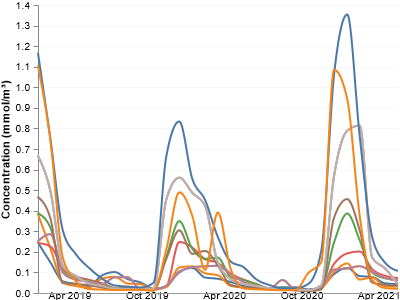

In [4]:
spec=json.loads("""
{
  "schema": "https://vega.github.io/schema/vega/v5.json",
  "description": "Chemical concentration of various nutrient-type molecules at river mouths in corresponding basin",
  "width": 400,
  "height": 250,
  "padding": 0,
  "autosize": {"type": "fit", "contains": "padding"},
  "signals": [
    {
      "name": "variable",
      "description": "Chemical/product of interest",
      "value": "no3"
    }
  ],
  "data": [
    {
      "name": "table",
      "url": "https://wri-rw.carto.com/api/v2/sql?q=SELECT subq.* FROM (SELECT identifier AS hyriv_id, hybas_id, variable_a AS variable, date, AVG(value) AS avg_value, variable_c AS ord_flow FROM ow_widget_basin_demo WHERE hybas_id = '1050030460' GROUP BY identifier, hybas_id, variable_a, date, variable_c) AS subq ",
      "format": {
        "type": "json",
        "property": "rows",
        "parse": {
          "date": "utc:'%Y-%m-%d %H:%M:%S'"
        }
      },
      "transform": [
        {
          "type": "filter",
          "expr": "datum.variable==variable"
        },
        {
          "type": "collect",
          "sort": {
            "field": "date"
          }
        }
      ]
    }
  ],
  "scales": [
    {
      "name": "xscale",
      "type": "time",
      "domain": {
        "data": "table",
        "field": "date"
      },
      "range": "width",
      "padding": 0
    },
    {
      "name": "yscale",
      "type": "linear",
      "domain": {
        "data": "table",
        "field": "avg_value"
      },
      "nice": true,
      "range": "height"
    },
    {
      "name": "colorscale",
      "type": "ordinal",
      "range": "category",
      "domain": {
        "data": "table",
        "field": "hyriv_id"
      }
    },
    {
      "name": "lineweight",
      "type": "ordinal",
      "domain": [
        1,
        2,
        3,
        4,
        5
      ],
      "range": [
        4,
        3.5,
        3,
        2.5,
        2
      ]
    }
  ],
  "axes": [
    {
      "orient": "bottom",
      "scale": "xscale",
      "labelFlush": true,
      "labelOverlap": true,
      "labelBaseline": "middle",
      "ticks": false,
      "labelFontSize": 10,
      "labelFont": "Arial",
      "format": "%b %Y"
    },
    {
      "orient": "left",
      "scale": "yscale",
      "title": {
        "signal": "'Concentration (mmol/m³)'"
      },
      "labelBaseline": "middle",
      "labelAlign": "right",
      "labelPadding": 3,
      "grid": true,
      "gridOpacity": 0.2,
      "labelFontSize": 10,
      "labelFont": "Arial"
    }
  ],
  "marks": [
    {
      "type": "group",
      "from": {
        "facet": {
          "name": "series",
          "data": "table",
          "groupby": "hyriv_id"
        }
      },
      "marks": [
        {
          "type": "line",
          "from": {
            "data": "series"
          },
          "encode": {
            "enter": {
              "interpolate": {
                "value": "monotone"
              },
              "x": {
                "scale": "xscale",
                "field": "date"
              },
              "y": {
                "scale": "yscale",
                "field": "avg_value"
              },
              "stroke": {
                "scale": "colorscale",
                "field": "hyriv_id"
              },
              "strokeWidth": {
                "scale": "lineweight",
                "field": "ord_flow"
              },
              "tooltip": {
                "signal": "{'River ID':datum.hyriv_id, 'Date':timeFormat(datum.date, '%B %Y'), 'Concentration':format(datum.avg_value, '.3f')+' mmol/m^3'}"
              }
            },
            "update": {
              "strokeOpacity": {
                "value": 1
              }
            },
            "hover": {
              "strokeOpacity": {
                "value": 0.5
              }
            }
          }
        }
      ]
    }
  ]
}
""")
vega_view=dict(spec)
vega_view['width']=widget_width
vega_view['height']=widget_height
Vega(vega_view)

# RW API

Parameterized widgets created via [widget scripts](https://github.com/resource-watch/data-team-tools/tree/master/advanced_widget_writer).  

## Nitrate
[ocn.020a.rw0 Ocean Nitrate Concentration](https://resourcewatch.org/data/explore/ocn020a-Nitrate-Concentration) ([Admin](https://resourcewatch.org/admin/data/datasets/92327c78-a473-402b-8edf-409869823216/edit))  
`92327c78-a473-402b-8edf-409869823216`  
[Dataset](https://api.resourcewatch.org/v1/dataset/92327c78-a473-402b-8edf-409869823216/), [Widgets](https://api.resourcewatch.org/v1/dataset/92327c78-a473-402b-8edf-409869823216/widget)

In [2]:
dataset_id = '92327c78-a473-402b-8edf-409869823216'
name = 'Nitrate Concentration at River Mouths in Basin'
description = 'Time series data of nitrate concentrations at river mouths within the basin'

- [Nitrate](https://api.resourcewatch.org/v1/widget/80b7addc-f6ea-4d38-808c-359e49a8b84e?env=production) `80b7addc-f6ea-4d38-808c-359e49a8b84e`  

## Phosphate
[ocn.020b.rw0 Ocean Phosphate Concentration](https://resourcewatch.org/data/explore/ocn020b-Mole-Concentration-of-Nitrate) ([Admin](https://resourcewatch.org/admin/data/datasets/f1aa9ec7-c3b6-441c-b395-96fc796b7612/edit))  
`f1aa9ec7-c3b6-441c-b395-96fc796b7612`  
[Dataset](https://api.resourcewatch.org/v1/dataset/f1aa9ec7-c3b6-441c-b395-96fc796b7612/), [Widgets](https://api.resourcewatch.org/v1/dataset/f1aa9ec7-c3b6-441c-b395-96fc796b7612/widget)

In [2]:
dataset_id = 'f1aa9ec7-c3b6-441c-b395-96fc796b7612'
name = 'Phosphate Concentration at River Mouths in Basin'
description = 'Time series data of phosphate concentrations at river mouths within the basin'

- [Phosphate](https://api.resourcewatch.org/v1/widget/d0b57543-e771-41e1-a9b6-a9487d5c3d5b?env=production) `d0b57543-e771-41e1-a9b6-a9487d5c3d5b`  

## Oxygen
[ocn.020c.rw0 Ocean Dissolved Oxygen Concentration](https://resourcewatch.org/data/explore/ocn020c-Dissolved-Oxygen-Concentration) ([Admin](https://resourcewatch.org/admin/data/datasets/877cdf39-5536-409c-bcba-2220e1b72796/edit))  
`877cdf39-5536-409c-bcba-2220e1b72796`  
[Dataset](https://api.resourcewatch.org/v1/dataset/877cdf39-5536-409c-bcba-2220e1b72796/), [Widgets](https://api.resourcewatch.org/v1/dataset/877cdf39-5536-409c-bcba-2220e1b72796/widget)

In [11]:
dataset_id = '877cdf39-5536-409c-bcba-2220e1b72796'
name = 'Dissolved Oxygen Concentration at River Mouths in Basin'
description = 'Time series data of dissolved oxygen concentrations at river mouths within the basin'

- [Oxygen](https://api.resourcewatch.org/v1/widget/3f531725-9d1f-436f-85f8-b1494b0262c1?env=production) `3f531725-9d1f-436f-85f8-b1494b0262c1`  